# Comparing Anomaly detection models
We want to know what anomaly detection model(s) work best, we will start with using the ping round trip time, there is a lot of diversity in the data, and it is easy to access.

The data selected is from an anchoring measurement towards an anchor located in San Fransisco, around the time of an internet outage from Fastly [1].
According to the article the outage should be around 11:00 UTC on june 8th. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import perf_counter
from measurement_import import PingImport
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from luminol.anomaly_detector import AnomalyDetector

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload

In [ ]:
ping_import = PingImport()
df = ping_import.download_dataset('34790576')

In [ ]:
ping_import = PingImport()
df = ping_import.download_dataset_old('34790576')

## Data import

Because opening the JSON takes very long, this is the dataset with all irrelevant columns removed.

In [3]:
ping_import = PingImport()
df = ping_import.read_dataset('measurement_data/ping-measurement_1.json')
df = df.dropna()
df

,probe_id,created,rtt_min,rtt_average,packets_loss
0,6025,2021-06-07 00:02:11+00:00,149.195256,149.218,0.0
1,6030,2021-06-07 00:02:21+00:00,166.409528,166.576,0.0
2,6031,2021-06-07 00:02:22+00:00,149.048305,149.319,0.0
3,6039,2021-06-07 00:02:21+00:00,170.077631,170.098,0.0
4,6041,2021-06-07 00:02:17+00:00,173.588153,173.648,0.0
...,...,...,...,...,...
678089,7006,2021-06-09 23:58:21+00:00,147.811359,147.874,0.0
678090,7007,2021-06-09 23:58:17+00:00,208.128699,208.156,0.0
678091,7008,2021-06-09 23:58:09+00:00,162.276314,162.362,0.0
678092,7009,2021-06-09 23:58:08+00:00,219.913387,219.927,0.0


# Adding extra columns
To be able to more easily compare results between probes, the min round trip time median is taken as zero. The min round trip time is taken since this measurement is less sensative towards outliers (and so will be less likely to result in False Positive anomalies)

In [4]:
# Add row with difference to median for rtt_min
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_min"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_min_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_min'])

In [5]:
# Add row with difference to median for rtt_average
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_average"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_average_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_average'])

In [6]:
# Add row with median rtt per probe 
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median = single_probe["rtt_min"].median()
    df.loc[df['probe_id'] == i, 'probe_rtt_median'] = median

## Per probe anomaly detection and visualisation
It is possible to change the random value to see the graph for a random different probe, (or uncomment to pick specific probes). Detected anomalys are marked with red dots. For anomaly detecion the fast and easy isolation forest is used. This can later be compared to other algorithms, but in the sake off working agile has to serve right now.
A problem with isolation forest is the fact that upfront the expected percentage of anomalies has to be specified. This can be different for each probe and is not known.

Probe ID: 7003
Median RTT: 151.566293 Average RTT: 151.74028497037045
Amount of data points: 1080
Isolation Forest duration: 0.4191475170009653
Local Outlier Factor duration: 0.010287886001606239
One Class duration: 0.14009539000107907
Luminol duration: 0.11636211999939405


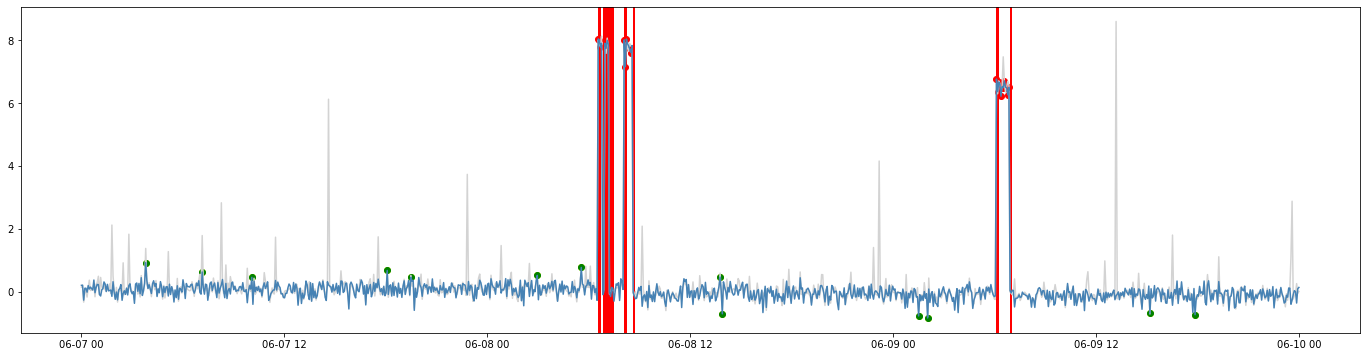

In [7]:
random_probe = df["probe_id"].sample(n=1, random_state=60).unique()[0]
# random_probe = 6229
print(f"Probe ID: {random_probe}")
single_probe1 = df[df["probe_id"] == random_probe]
single_probe1_median = single_probe1["rtt_min"].median()
single_probe1_mean = single_probe1["rtt_min"].mean()

print(f"Median RTT: {single_probe1_median} Average RTT: {single_probe1_mean}")

single_probe1_datapoints = len(single_probe1)
print(f"Amount of data points: {single_probe1_datapoints}")

start_if = perf_counter()
# Outlier detection
if_clf = IsolationForest(contamination=0.02)
single_probe1["isolation_forest"] = if_clf.fit_predict(single_probe1[["rtt_min"]])
lenght_if = perf_counter() - start_if

start_lf = perf_counter()
lf_clf = LocalOutlierFactor(n_neighbors=15)
single_probe1["local_outlier"] = lf_clf.fit_predict(single_probe1[["rtt_min"]])
lenght_lf = perf_counter() - start_lf

start_svc = perf_counter()
svc_clf = OneClassSVM()
single_probe1["one_class"] = svc_clf.fit_predict(single_probe1[["rtt_min"]])
lenght_svc = perf_counter() - start_svc

# Anomaly detection
algo_settings = {
      'precision':10, # how many sections to categorize values
      'lag_window_size':4, # lagging window size
      'future_window_size':4, # future window size,
      'chunk_size':10 # chunk size.
    }

start_luminol = perf_counter()
ts = single_probe1["rtt_min"].to_dict()
detector = AnomalyDetector(ts, algorithm_name="bitmap_detector", algorithm_params=algo_settings)
anomalies = detector.get_anomalies()
lenght_luminol = perf_counter() - start_luminol

fig, ax = plt.subplots(figsize=(24,6))

for anomaly in anomalies:
    start = single_probe1.at[anomaly.start_timestamp, "created"]
    end = single_probe1.at[anomaly.end_timestamp, "created"]
    score = anomaly.anomaly_score
    ax.axvspan(xmin=start, xmax=end, color="red")

isolation_f = single_probe1.loc[single_probe1['isolation_forest'] == -1, ['created', 'rtt_min_diff']]
local_o = single_probe1.loc[single_probe1['local_outlier'] == -1, ['created', 'rtt_min_diff']]
oneclass = single_probe1.loc[single_probe1['local_outlier'] == -1, ['created', 'rtt_min_diff']]

ax.scatter(isolation_f["created"], isolation_f["rtt_min_diff"], color="red")
ax.scatter(local_o["created"], local_o["rtt_min_diff"], color="yellow")
ax.scatter(oneclass["created"], oneclass["rtt_min_diff"], color="green")

ax.plot(single_probe1['created'], single_probe1['rtt_average_diff'], color='lightgrey')
ax.plot(single_probe1['created'], single_probe1['rtt_min_diff'], color='steelblue')

# ax.legend(loc="upper left")

print(f'Isolation Forest duration: {lenght_if}')
print(f'Local Outlier Factor duration: {lenght_lf}')
print(f'One Class duration: {lenght_svc}')
print(f'Luminol duration: {lenght_luminol}')

plt.show()

<AxesSubplot:xlabel='rtt_min_diff', ylabel='Count'>

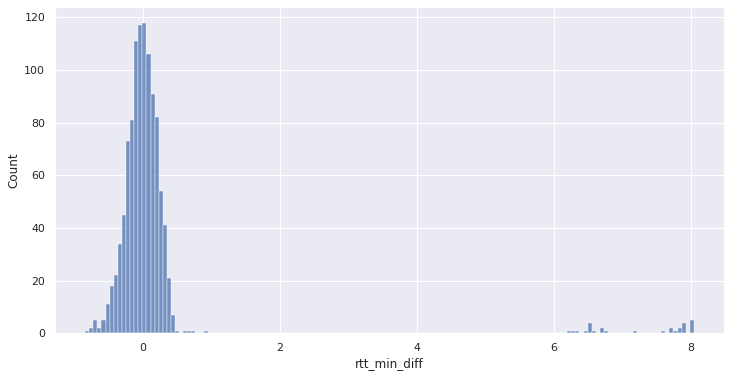

In [8]:
# check distribution
sns.set(rc={"figure.figsize":(12, 6)})
sns.histplot(data=single_probe1, x="rtt_min_diff")

# Per probe with baseline

The next test uses the first day as baseline data, and the predicts on the second timeseries to see if this improves results.

Probe ID: 6448


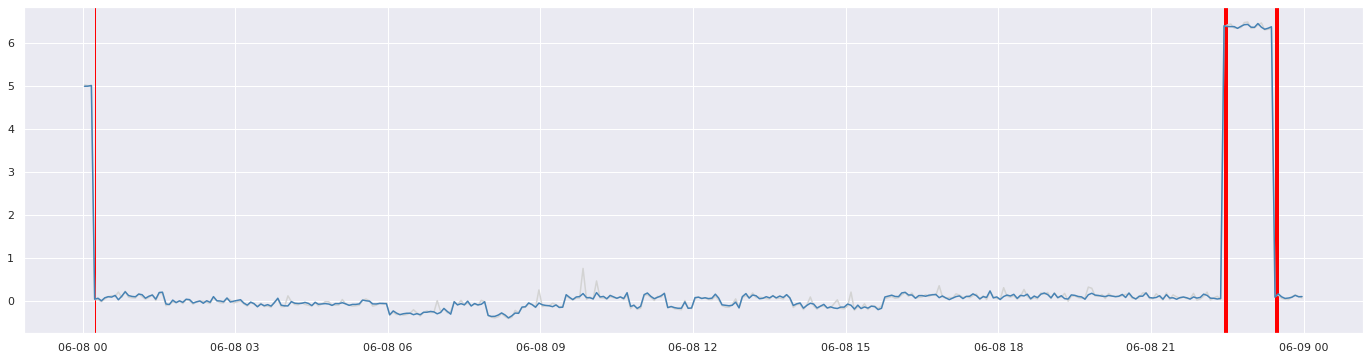

In [72]:
random_probe = df["probe_id"].sample(n=1, random_state=37).unique()[0]
# random_probe = 6229
print(f"Probe ID: {random_probe}")
single_probe1 = df[df["probe_id"] == random_probe]

baseline = single_probe1[single_probe1['created'] < '2021-06-08']
check_range = single_probe1[(single_probe1['created'] < '2021-06-09') & (single_probe1['created'] > '2021-06-08')]

# Anomaly detection
algo_settings = {
    #   'precision':20, # how many sections to categorize values
    #   'lag_window_size':25, # lagging window size
    #   'future_window_size':22, # future window size,
    #   'chunk_size':10 # chunk size.
        'smoothing_factor': 0.15,
    }

start_luminol = perf_counter()
ts_baseline = baseline["rtt_min"].to_dict()
ts_check = check_range["rtt_min"].to_dict()
detector = AnomalyDetector(ts_check, ts_baseline, algorithm_name="exp_avg_detector", algorithm_params=algo_settings)
anomalies = detector.get_anomalies()
lenght_luminol = perf_counter() - start_luminol

fig, ax = plt.subplots(figsize=(24,6))

for anomaly in anomalies:
    start = check_range.at[anomaly.start_timestamp, "created"]
    end = check_range.at[anomaly.end_timestamp, "created"]
    score = anomaly.anomaly_score
    ax.axvspan(xmin=start, xmax=end, color="red")

ax.plot(check_range['created'], check_range['rtt_average_diff'], color='lightgrey')
ax.plot(check_range['created'], check_range['rtt_min_diff'], color='steelblue')

plt.show()


## References
[1] “Internet Fastly Outage: Multiple Major Websites Went Offline : NPR.” https://www.npr.org/2021/06/08/1004305569/internet-fastly-outage-go-down-twitter-reddit?t=1636636476400 (accessed Dec. 02, 2021).
[2] P. Dilini Talagala, R. J. Hyndman, K. Smith-Miles, S. Kandanaarachchi, and M. A. Munoz, “Anomaly Detection in Streaming Nonstationary Temporal Data Anomaly Detection in Streaming Nonstationary Temporal Data Anomaly Detection in Streaming Nonstationary Temporal Data,” 2018, Accessed: Nov. 04, 2021. [Online]. Available: http://business.monash.edu/econometrics-and-business-statistics/research/publications.